In [51]:
import pickle
import xarray as xr
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
import numpy
import matplotlib.pyplot as plt

Here we evaluate the robustness of each of the 6 atmospheric inversion models to the Global Carbon Project observations.<br><br>
Note that GCP land flux = land (from DGVMs) + BIM (budget imbalance) which represents the residual flux. This keeps the analysis consistent with comparing models to observations (GCP).

In [2]:
# Models
CAMS = pd.read_csv("./../Output/output_raw/output_CAMS.csv").set_index("Year")
CTRACKER = pd.read_csv("./../Output/output_raw/output_CTRACKER.csv").set_index("Year")
Rayner = pd.read_csv("./../Output/output_raw/output_Rayner.csv").set_index("Year")
JAMSTEC = pd.read_csv("./../Output/output_raw/output_JAMSTEC.csv").set_index("Year")
JENA_s76 = pd.read_csv("./../Output/output_raw/output_JENA_s76.csv").set_index("Year")
JENA_s85 = pd.read_csv("./../Output/output_raw/output_JENA_s85.csv").set_index("Year")

In [3]:
#GCP
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
df = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5,6])
df.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,0.852376,0.516073,0.860316
1960,0.819017,1.394030,0.522722
1961,0.714842,0.605098,1.213762
1962,0.756709,1.348349,0.959605
1963,0.904997,0.877794,1.355333


In [4]:
fCO2 = './../co2_temp_data/co2_global.csv'
CO2 = pd.read_csv(fCO2, index_col=0)[2:]
CO2.head()

,CO2
Year,
1959,315.486
1960,316.163
1961,316.856
1962,317.558
1963,318.268


In [5]:
df['CO2'] = CO2
df['land sink'] = -df['land sink']
df['ocean sink'] = -df['ocean sink']
df['budget imbalance'] = -df["budget imbalance"]+df['land sink']

df.head()

,ocean sink,land sink,budget imbalance,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [6]:
df.rename(columns={"ocean sink": "ocean", "land sink": "land (model)", "budget imbalance": "land"},
         inplace=True)
df.head()

,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


# Plots

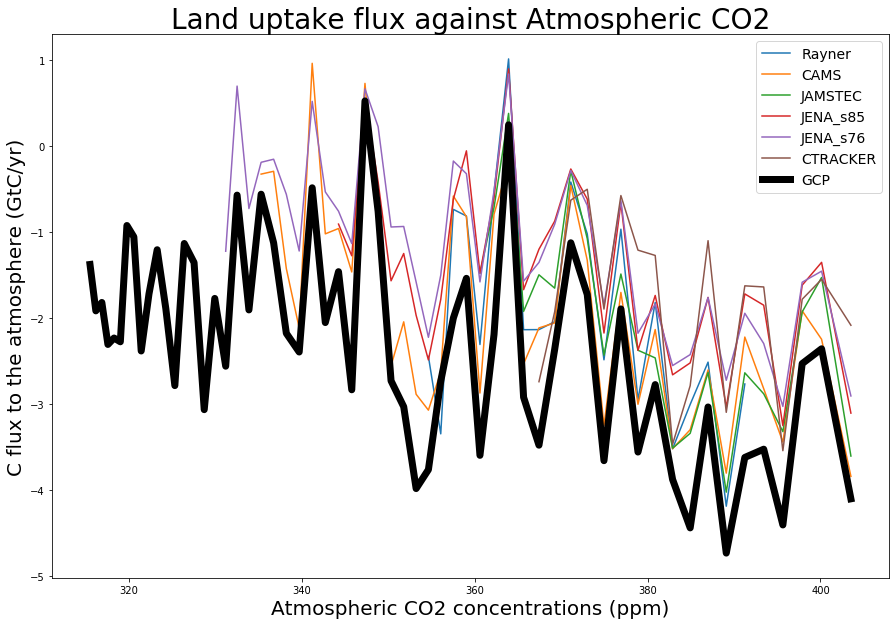

In [7]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Land)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Land)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Land)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Land)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Land)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Land)
plt.plot(df.CO2, df.land, linewidth=7, color='k')

plt.title("Land uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [8]:
pickle.dump([df.CO2, df.land], open("./GCP_land.pik", "wb"))

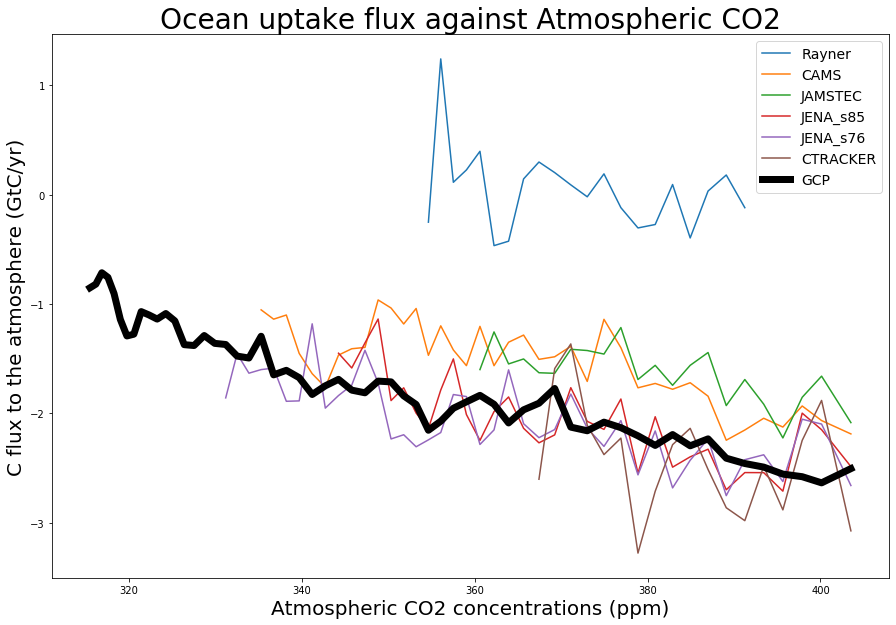

In [9]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Ocean)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Ocean)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Ocean)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Ocean)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Ocean)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Ocean)
plt.plot(df.CO2, df.ocean, linewidth=7, color='k')

plt.title("Ocean uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [10]:
pickle.dump([df.CO2, df.ocean], open("./GCP_ocean.pik", "wb"))

# Global Uptake timeseries

In [11]:
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
GCB = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5,6])
GCB = -GCB
GCB.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,-0.852376,-0.516073,-0.860316
1960,-0.819017,-1.394030,-0.522722
1961,-0.714842,-0.605098,-1.213762
1962,-0.756709,-1.348349,-0.959605
1963,-0.904997,-0.877794,-1.355333


In [35]:
def model_GCP_evaluation(model, sink="land sink"):
    
    plt.figure(figsize=(14,9))
    plt.subplot(211).plot(model.index, GCB.loc[model.index][sink])
    plt.subplot(211).plot(model.index, model.Earth_Land)
    plt.legend()
    plt.subplot(212).scatter(GCB.loc[model.index][sink], model.Earth_Land)
    
    return stats.linregress(GCB.loc[model.index][sink], model.Earth_Land)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
No handles with labels found to put in legend.


LinregressResult(slope=0.7654909291344756, intercept=0.7449810716426817, rvalue=0.7632484567409027, pvalue=4.173736814427203e-09, stderr=0.10245833257091637)

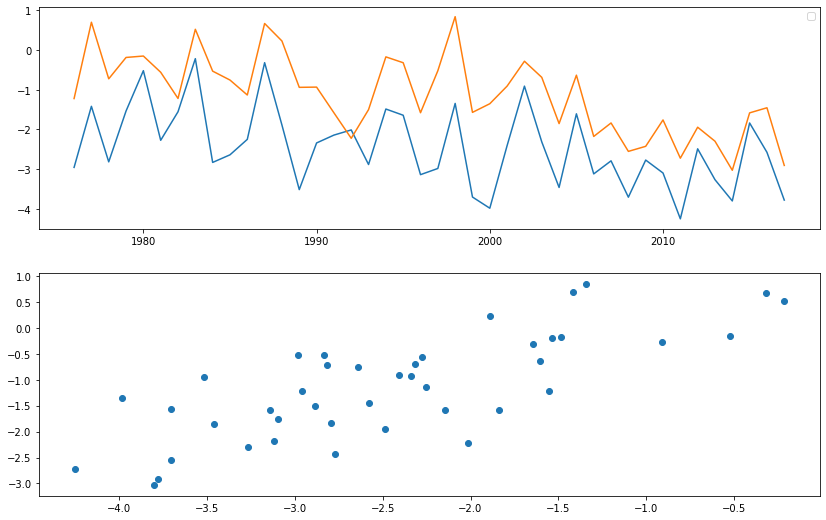

In [80]:
model_GCP_evaluation(JENA_s76)

In [81]:
power_spec = signal.periodogram(GCB["land sink"], fs=1)
power_spec

(array([0.        , 0.01694915, 0.03389831, 0.05084746, 0.06779661,
        0.08474576, 0.10169492, 0.11864407, 0.13559322, 0.15254237,
        0.16949153, 0.18644068, 0.20338983, 0.22033898, 0.23728814,
        0.25423729, 0.27118644, 0.28813559, 0.30508475, 0.3220339 ,
        0.33898305, 0.3559322 , 0.37288136, 0.38983051, 0.40677966,
        0.42372881, 0.44067797, 0.45762712, 0.47457627, 0.49152542]),
 array([8.35657739e-34, 1.15491647e+01, 5.53038909e+00, 6.64477231e+00,
        2.91859887e-01, 2.20831424e+00, 7.11589695e-01, 2.56377711e+00,
        7.49004060e-01, 3.38450500e-02, 1.89870582e-01, 2.38649435e+00,
        3.27919066e-01, 1.85708865e+00, 7.88094206e-01, 1.15019235e+00,
        8.73955075e+00, 5.24368663e+00, 3.81128869e+00, 1.76182614e-01,
        7.07203238e-01, 4.74886480e-01, 2.71699219e+00, 2.94803795e+00,
        2.03244697e+00, 3.28499051e-01, 1.92446564e-01, 1.77700055e+00,
        5.41148223e-01, 1.52811155e+00]))

(0.01, 100.0)

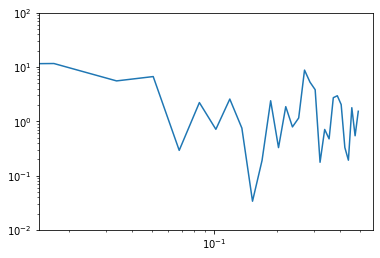

In [88]:
plt.loglog(power_spec[0], power_spec[1])
plt.ylim([10e-3,10e1])

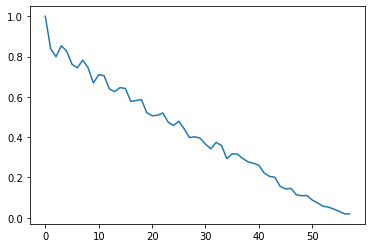

In [108]:
auto_cor = signal.correlate(GCB["land sink"], GCB["land sink"])
halfway_index = int((len(auto_cor)+1)/2)-1
plt.plot(auto_cor[halfway_index:-1]/auto_cor[halfway_index])

Other things to do:
- Frequency correlation
- Cross-correlation
- Refer to stats course (sem 1) for more things to do

# Rolling gradient